# Import necessary libraries

In [211]:
import pandas as pd
import numpy as np

from scipy import stats
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load training dataset

In [212]:
# read csv file
loan_data = pd.read_csv('loan-train.csv')

# check shape of the dataset
loan_data.shape

(614, 13)

In [213]:
#check first firve rows of the dataset
loan_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [214]:
#output features name
print(loan_data.columns)

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')


In [215]:
#check dataset information
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


# Check for the missing or null values in the dataset

In [216]:
loan_data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [217]:
# Investigate loan id feature as it seems to be a unique value for each person
loan_data['Loan_ID'].value_counts().sum()

614

# Remove Label_ID feature as it does not provide any useful information for the model

In [218]:
loan_data = loan_data.drop(['Loan_ID'], axis=1)

# Data Exploration

In [219]:
# get the categorical feature names
categorical_columns = [column for column in loan_data.columns if loan_data[column].dtype == 'object']
print(categorical_columns)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


## Check value count for each categorical feature

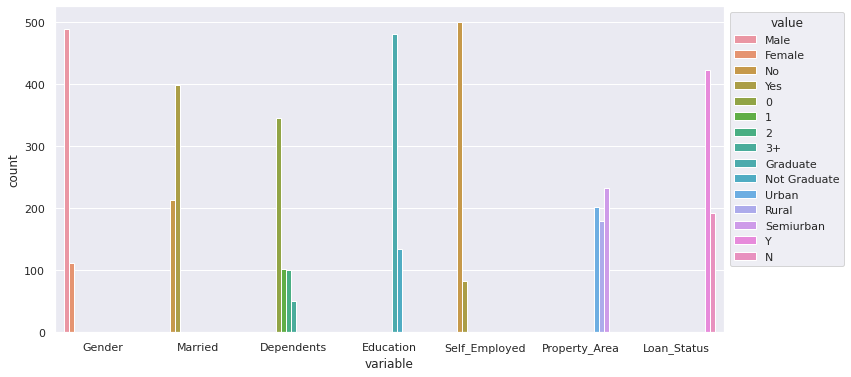

In [220]:
# Initialise the figure size
plt.figure(figsize = (12, 6))
ax = sns.countplot(x="variable", hue="value", data=pd.melt(loan_data[categorical_columns]))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

## check few important feature relationship with others

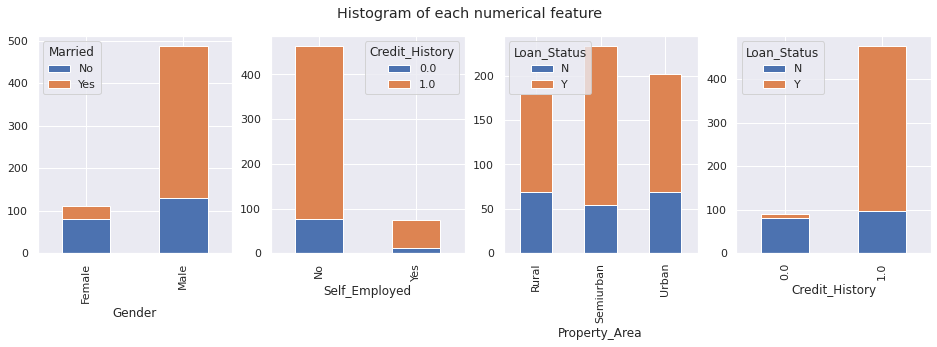

In [221]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Histogram of each numerical feature')
pd.crosstab(loan_data.Gender,loan_data.Married).plot(ax = axes[0], kind="bar", stacked=True)
pd.crosstab(loan_data.Self_Employed,loan_data.Credit_History).plot(ax = axes[1], kind="bar", stacked=True)
pd.crosstab(loan_data.Property_Area,loan_data.Loan_Status).plot(ax = axes[2], kind="bar", stacked=True)
pd.crosstab(loan_data.Credit_History,loan_data.Loan_Status).plot(ax = axes[3], kind="bar", stacked=True)
plt.show()


In [222]:
# get the numerical feature names
numerical_columns = [column for column in loan_data.columns if loan_data[column].dtype != 'object']
print(numerical_columns)

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


In [223]:
# check descriptive statistics of numercial features
loan_data[numerical_columns].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


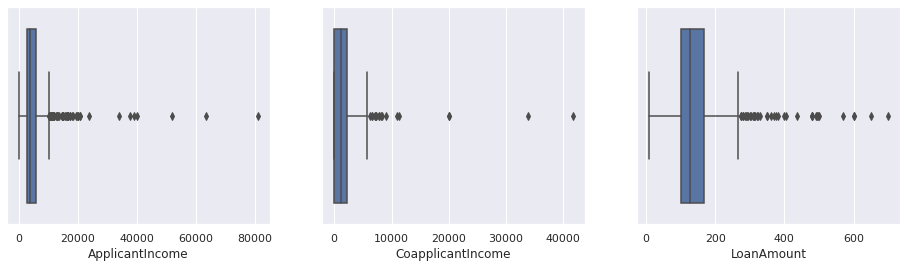

In [224]:
#Check the box plot of numerical features
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.boxplot(data=loan_data, x = 'ApplicantIncome', ax = axes[0])
sns.boxplot(data=loan_data, x = 'CoapplicantIncome', ax = axes[1])
sns.boxplot(data=loan_data, x = 'LoanAmount', ax = axes[2])
plt.show()

# Remove Outliers

In [225]:
loan_data = loan_data[loan_data['ApplicantIncome'] <= 12500]
loan_data = loan_data[loan_data['CoapplicantIncome'] <= 7000]
loan_data = loan_data[loan_data['LoanAmount'] <= 300]

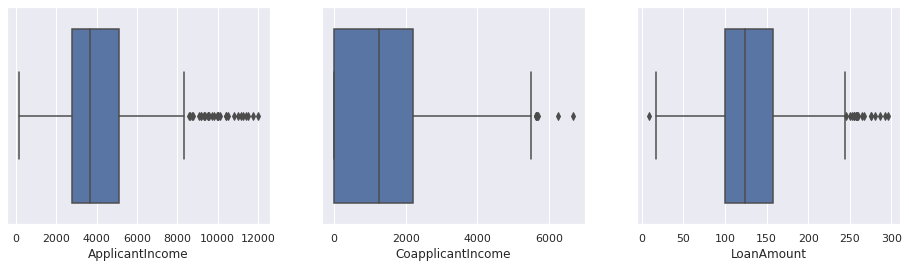

In [226]:
#Check the box plot of numerical features
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.boxplot(data=loan_data, x = 'ApplicantIncome', ax = axes[0])
sns.boxplot(data=loan_data, x = 'CoapplicantIncome', ax = axes[1])
sns.boxplot(data=loan_data, x = 'LoanAmount', ax = axes[2])
plt.show()

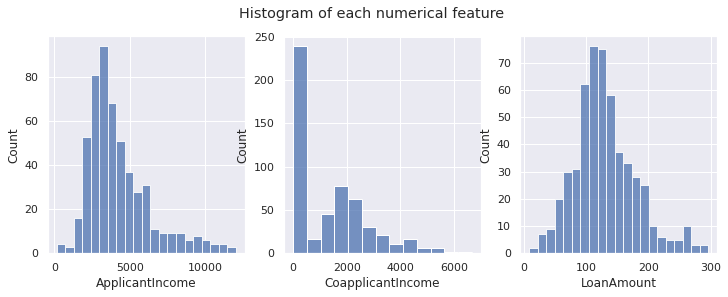

In [227]:
# check histogrqam of the numerical data
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Histogram of each numerical feature')
sns.histplot(ax=axes[0], data = loan_data['ApplicantIncome'])
sns.histplot(ax=axes[1], data = loan_data['CoapplicantIncome'])
sns.histplot(ax=axes[2], data = loan_data['LoanAmount'])
plt.show()

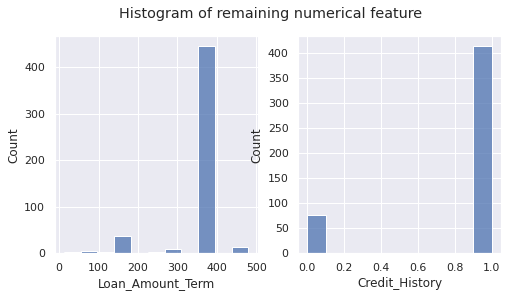

In [228]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Histogram of remaining numerical feature')
sns.histplot(ax=axes[0], data = loan_data['Loan_Amount_Term'])
sns.histplot(ax=axes[1], data = loan_data['Credit_History'])
plt.show()

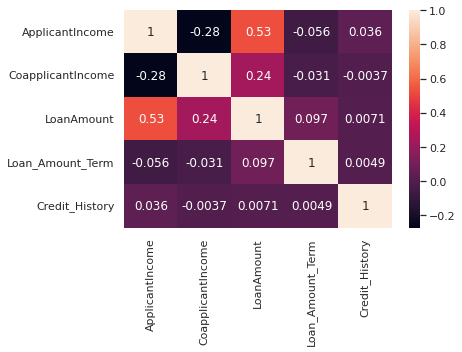

In [229]:
# check the coorelation between numerical features
sns.heatmap(loan_data.corr(), annot = True)
plt.show()

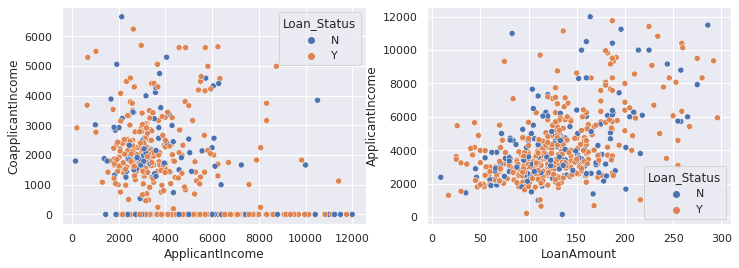

In [230]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(ax = axes[0], data = loan_data, x = 'ApplicantIncome', y= 'CoapplicantIncome', hue= 'Loan_Status')
sns.scatterplot(ax = axes[1], data = loan_data, x = 'LoanAmount', y= 'ApplicantIncome', hue= 'Loan_Status')
plt.show()

# Remove null and missing values from the dataset

In [231]:
for column in loan_data.columns:
    loan_data[column].fillna(loan_data[column].mode()[0], inplace = True)


In [232]:
# confirm that the there are no missing values in the dataset
print(loan_data.isnull().sum())

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


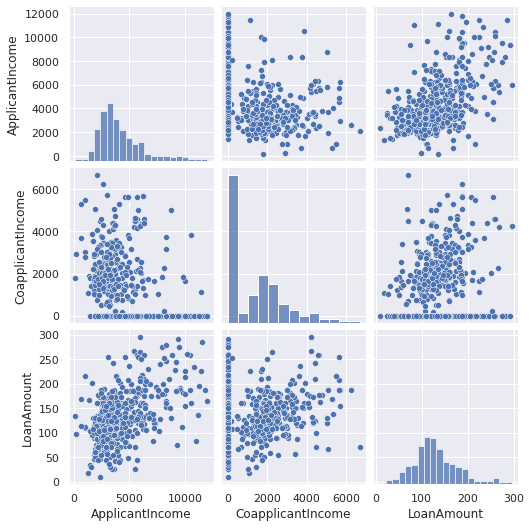

In [233]:
# check pair plot of the import numerical features
sns.pairplot(data=loan_data[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])
plt.show()

# Get one hot coded features for catergocial values

In [234]:
loan_data = pd.get_dummies(loan_data, drop_first=True)

In [235]:
from numpy import percentile
# calculate interquartile range
q25, q75 = percentile(loan_data.ApplicantIncome, 25), percentile(loan_data.ApplicantIncome, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in loan_data.ApplicantIncome if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

Percentiles: 25th=2786.000, 75th=5083.000, IQR=2297.000
Identified outliers: 32


# Check data distribution of the income and loan amount

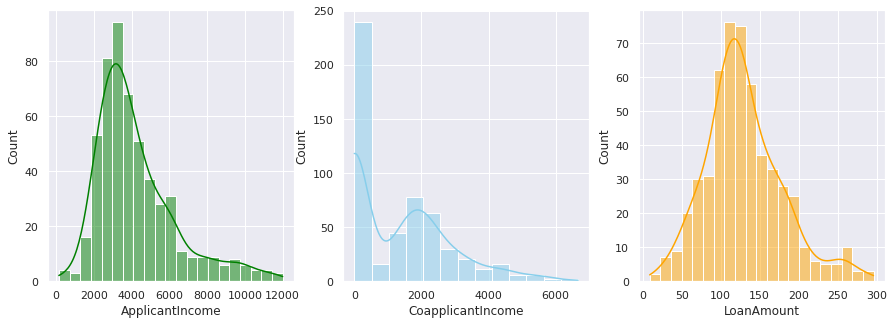

In [237]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(data=loan_data, x="ApplicantIncome", kde=True, ax=axs[0], color='green')
sns.histplot(data=loan_data, x="CoapplicantIncome", kde=True, ax=axs[1], color='skyblue')
sns.histplot(data=loan_data, x="LoanAmount", kde=True, ax=axs[2], color='orange');

# Apply sqrt transformation to bring data into gaussian distribution

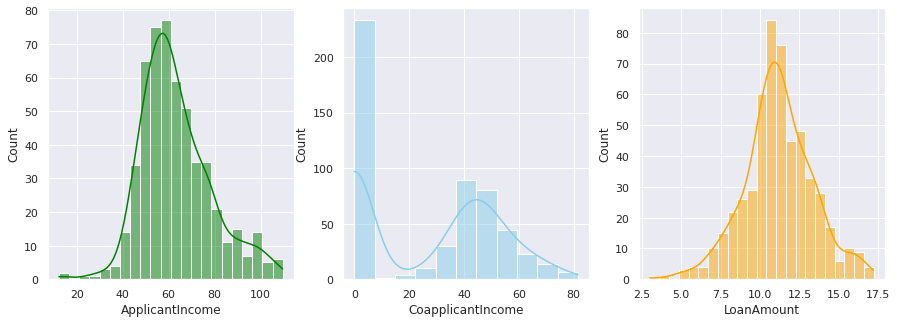

In [238]:
from scipy import stats
# Log transform multiple columns in dataframe 
loan_data['ApplicantIncome'] = np.sqrt(loan_data['ApplicantIncome'])
loan_data['CoapplicantIncome'] = np.sqrt(loan_data['CoapplicantIncome'])
loan_data['LoanAmount'] = np.sqrt(loan_data['LoanAmount'])


sns.set(style="darkgrid")
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(data=loan_data, x="ApplicantIncome", kde=True, ax=axs[0], color='green')
sns.histplot(data=loan_data, x="CoapplicantIncome", kde=True, ax=axs[1], color='skyblue')
sns.histplot(data=loan_data, x="LoanAmount", kde=True, ax=axs[2], color='orange');

In [239]:
loan_data_X = loan_data.drop(['Loan_Status_Y'], axis=1)
loan_data_Y = loan_data['Loan_Status_Y']

In [240]:
loan_data_X.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
1,67.697858,38.832976,11.313708,360.0,1.0,1,1,1,0,0,0,0,0,0
2,54.772256,0.000000,8.124038,360.0,1.0,1,1,0,0,0,0,1,0,1
3,50.823223,48.559242,10.954451,360.0,1.0,1,1,0,0,0,1,0,0,1
4,77.459667,0.000000,11.874342,360.0,1.0,1,0,0,0,0,0,0,0,1
5,73.600272,64.776539,16.340135,360.0,1.0,1,1,0,1,0,0,1,0,1


In [241]:
loan_data_X.shape

(535, 14)

# Apply SMOTE transformation as the label are imblanced in the dataset

In [242]:
# X, y = SMOTE().fit_resample(loan_data_X, loan_data_Y)

In [243]:
X = MinMaxScaler().fit_transform(loan_data_X)

In [244]:
# sns.set_theme(style="darkgrid")
# sns.countplot(y=y, data=loan_data, palette="coolwarm")
# plt.ylabel('Loan Status')
# plt.xlabel('Total')
# plt.show()

# Divide the dataset into training and validation dataset

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X, loan_data_Y, test_size=0.2, random_state = 27)

# Model prepratation

# Build model using the following algorithms

- Logistic Regression
- K-Nearest Neighbour (KNN)
- Support Vector Machine (SVM)
- Decision Tree
- Random Forest
- Gradient Boost

## Logistic regression

In [246]:
model_lr = LogisticRegression(max_iter=500)
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

lr_acc = accuracy_score(y_pred,y_test)
print('LR accuracy: {:.2f}%'.format(lr_acc*100))

              precision    recall  f1-score   support

           0       0.94      0.64      0.76        25
           1       0.90      0.99      0.94        82

    accuracy                           0.91       107
   macro avg       0.92      0.81      0.85       107
weighted avg       0.91      0.91      0.90       107

[[16  9]
 [ 1 81]]
LR accuracy: 90.65%


# Logistic Regression with Polynomial Feature 

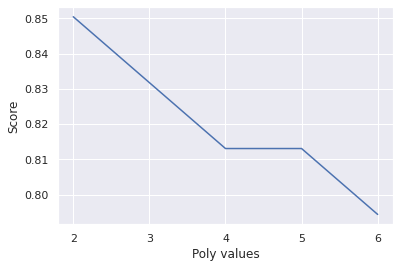

PLR best accuracy: 85.05%


In [247]:
from sklearn.preprocessing import PolynomialFeatures
model_plr = LogisticRegression(max_iter=500)
score_plr = []
for i in range(2, 7):
    poly = PolynomialFeatures(degree = i)
    X_poly = poly.fit_transform(X_train)

    model_plr.fit(X_poly, y_train)
    X_poly_test = poly.transform(X_test)
    score_plr.append(model_plr.score(X_poly_test, y_test))

plt.plot(range(2, 7), score_plr)
plt.xticks(np.arange(2, 7, 1))
plt.xlabel("Poly values")
plt.ylabel("Score")
plt.show()
PLR_Acc = max(score_plr)
print("PLR best accuracy: {:.2f}%".format(PLR_Acc*100))


## Support Vector Machine

In [248]:
model_svc = SVC(kernel='rbf')
model_svc.fit(X_train, y_train)

y_pred = model_svc.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

SVC_Acc = accuracy_score(y_pred,y_test)
print('SVC accuracy: {:.2f}%'.format(SVC_Acc*100))

              precision    recall  f1-score   support

           0       0.94      0.64      0.76        25
           1       0.90      0.99      0.94        82

    accuracy                           0.91       107
   macro avg       0.92      0.81      0.85       107
weighted avg       0.91      0.91      0.90       107

[[16  9]
 [ 1 81]]
SVC accuracy: 90.65%


## K-nearest neighbor

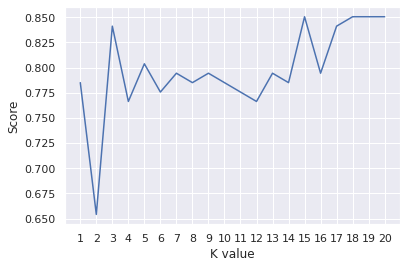

KNN best accuracy: 85.05%


In [249]:
score_knn = []
for i in range(1,21):
    model_knn = KNeighborsClassifier(n_neighbors = i)
    model_knn.fit(X_train, y_train)
    score_knn.append(model_knn.score(X_test, y_test))
    
plt.plot(range(1,21), score_knn)
plt.xticks(np.arange(1,21,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()
KNN_Acc = max(score_knn)
print("KNN best accuracy: {:.2f}%".format(KNN_Acc*100))

## Gaussian Naive Bayes

In [250]:
model_gnb = GaussianNB()
model_gnb.fit(X_train, y_train)

y_pred = model_gnb.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

GNB_Acc = accuracy_score(y_pred,y_test)
print('Gaussian Naive Bayes accuracy: {:.2f}%'.format(GNB_Acc*100))

              precision    recall  f1-score   support

           0       0.76      0.64      0.70        25
           1       0.90      0.94      0.92        82

    accuracy                           0.87       107
   macro avg       0.83      0.79      0.81       107
weighted avg       0.86      0.87      0.87       107

[[16  9]
 [ 5 77]]
Gaussian Naive Bayes accuracy: 86.92%


## Decision Tree

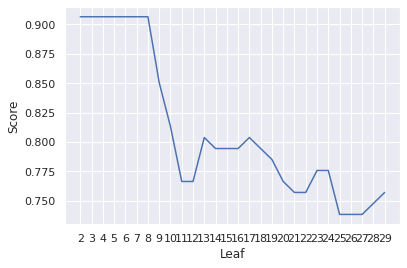

Decision Tree Accuracy: 90.65%


In [251]:
score_DT = []
for i in range(2,30):
    model_dt = DecisionTreeClassifier(max_leaf_nodes=i)
    model_dt.fit(X_train, y_train)
    score_DT.append(model_dt.score(X_test, y_test))
    
plt.plot(range(2,30), score_DT)
plt.xticks(np.arange(2,30,1))
plt.xlabel("Leaf")
plt.ylabel("Score")
plt.show()
DT_Acc = max(score_DT)
print("Decision Tree Accuracy: {:.2f}%".format(DT_Acc*100))

## Random Forest

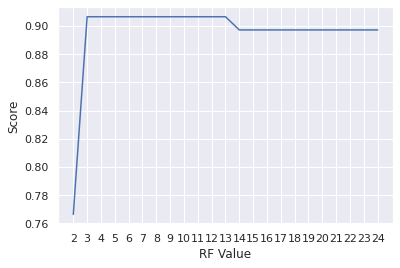

Random Forest Accuracy:  90.65%


In [252]:
score_RF = []
for i in range(2,25):
    model_rf = RandomForestClassifier(n_estimators = 1000, random_state = 1, max_leaf_nodes=i)
    model_rf.fit(X_train, y_train)
    score_RF.append(model_rf.score(X_test, y_test))
    
plt.plot(range(2,25), score_RF)
plt.xticks(np.arange(2,25,1))
plt.xlabel("RF Value")
plt.ylabel("Score")
plt.show()
RF_Acc = max(score_RF)
print("Random Forest Accuracy:  {:.2f}%".format(RF_Acc*100))

## Gradient Boosting

In [253]:
paramsGB={'n_estimators':[100,200,300,400,500],
      'max_depth':[1,2,3,4,5],
      'subsample':[0.5,1],
      'max_leaf_nodes':[2,5,10,20,30,40,50]}

In [254]:
GB = RandomizedSearchCV(GradientBoostingClassifier(), paramsGB, cv=20)
GB.fit(X_train, y_train)

RandomizedSearchCV(cv=20, estimator=GradientBoostingClassifier(),
                   param_distributions={'max_depth': [1, 2, 3, 4, 5],
                                        'max_leaf_nodes': [2, 5, 10, 20, 30, 40,
                                                           50],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.5, 1]})

In [255]:
print(GB.best_estimator_)
print(GB.best_score_)
print(GB.best_params_)
print(GB.best_index_)

GradientBoostingClassifier(max_depth=1, max_leaf_nodes=40, n_estimators=300,
                           subsample=1)
0.7969696969696971
{'subsample': 1, 'n_estimators': 300, 'max_leaf_nodes': 40, 'max_depth': 1}
3


In [256]:
model_gb = GradientBoostingClassifier(subsample=0.5, n_estimators=500, max_depth=5, max_leaf_nodes=40)
model_gb.fit(X_train, y_train)

y_pred = model_gb.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

GB_Acc = accuracy_score(y_pred,y_test)
print('Gradient Boosting accuracy: {:.2f}%'.format(GB_Acc*100))

              precision    recall  f1-score   support

           0       0.63      0.68      0.65        25
           1       0.90      0.88      0.89        82

    accuracy                           0.83       107
   macro avg       0.76      0.78      0.77       107
weighted avg       0.84      0.83      0.83       107

[[17  8]
 [10 72]]
Gradient Boosting accuracy: 83.18%


# Model selection

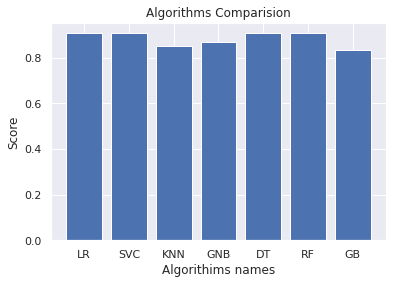

0.9065420560747663


In [257]:
scores = [lr_acc, SVC_Acc, KNN_Acc, GNB_Acc, DT_Acc, RF_Acc, GB_Acc]

plt.bar(range(len(scores)), scores)
plt.xticks(range(len(scores)), ['LR', 'SVC', 'KNN', 'GNB', 'DT', 'RF', 'GB'])
plt.title('Algorithms Comparision')
plt.xlabel("Algorithims names")
plt.ylabel("Score")
plt.show()

print(max(scores))

In [258]:
compare = pd.DataFrame({'Model': ['Logistic Regression', 'K Neighbors', 
                                  'SVM', 'Gaussian NB', 'Decision Tree', 
                                  'Random Forest', 'Gradient Boost'], 
                        'Accuracy': [lr_acc*100, KNN_Acc*100, SVC_Acc*100, 
                                     GNB_Acc*100, DT_Acc*100, 
                                     RF_Acc*100, GB_Acc*100]})
compare.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
0,Logistic Regression,90.654206
2,SVM,90.654206
4,Decision Tree,90.654206
5,Random Forest,90.654206
3,Gaussian NB,86.915888
1,K Neighbors,85.046729
6,Gradient Boost,83.177570


In [259]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer, fbeta_score
# TODO: Initialize the classifier
clf = SVC()

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01],'kernel': ['rbf', 'poly']}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring = scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.9065
F-score on testing data: 0.9163

Optimized Model
------
Final accuracy score on the testing data: 0.9065
Final F-score on the testing data: 0.9163


# Best accuracy is achieved by Logistic Regression Claasifier with 90.65% accuracy.
